<h1>Learned Perceptual Image Patch Similarity (LPIPS) metric</h1>

---
Criteria to evaluate diversity among images. Evaluate the distance between image patches. Higher means further/more different. Lower means more similar.
It can also be used as a <b>perceptual loss</b>


In [58]:
import lpips
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

Pretrained are used as a “perceptual loss" in image generation applications
(Here alexnet or vgg) 

In [51]:
loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores
loss_fn_vgg = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.6/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.6/dist-packages/lpips/weights/v0.1/vgg.pth


In [55]:
data_path = os.path.join("Output_images", "edges2shoes")
print(data_path)

Output_images/edges2shoes


In [56]:
class Results(Dataset):
  def __init__(self, root):
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
            ]
        )
        self.files = (glob.glob(root + "/*.*"))
  def __getitem__(self, index):
    img = Image.open(self.files[index % len(self.files)])
    img = self.transform(img)
    return img

  def __len__(self):
        return len(self.files)
    

In [57]:
dataloader = DataLoader(
    Results(data_path),
    batch_size=1,
    shuffle=False
)

After every 400 batches of training, we took a batch of 8 images from validation dataset. For each image generator produced 8 variants. For each image
we took all the 28 pairs possible and calculated the avg lpips distance between them. Then we took avg over all the 8 images.

In [27]:
div=[]     #list to store lpips distance after every 400 batches trained        
batches=[] #list of batches 
for batch in enumerate(dataloader):
  distance=0
  imgs_8=torch.split(batch[1],128,2)
  for img_8 in imgs_8:
    temp=0
    var=torch.split(img_8,128,3)
    for i in range(1,9):
      for j in range(i+1,9):
        img0=var[i]
        img1=var[j]
        diversity=loss_fn_alex(img0, img1)
        temp=(temp+diversity.item())
    distance=(distance+(temp/28))
  batches.append(batch[0]*400)
  div.append(distance/8)


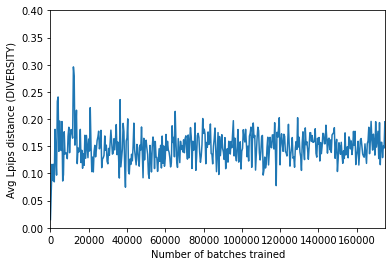

In [59]:
plt.plot(batches,div)
plt.axis([0, 175000, 0, 0.4])
plt.xlabel('Number of batches trained')
plt.ylabel('Avg Lpips distance (DIVERSITY)')
plt.show()

Random pairs of ground truth real images in the B ∈ B
domain produce an average variation of .262 (as illustrated in paper of bicyclegan) <br>
As we can see from the plot, our generated images have diversity close enough to real images.